In [1]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'Anomaly/data/NAB'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Mounted at /content/drive


In [2]:
import torch
import torch.utils.data
from torch.utils.data import DataLoader
import torchvision.transforms as T

from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets
from torchvision.utils import save_image
from torch.utils.data import sampler
import matplotlib.pyplot as plt

import numpy as np
from functools import partial
from dataclasses import dataclass
from collections import OrderedDict

In [3]:
USE_GPU = True
dtype = torch.float32

if USE_GPU and torch.cuda.is_available():

    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cpu


In [5]:
%cd /content/drive/My\ Drive/Anomaly/data/NAB

/content/drive/My Drive/Anomaly/data/NAB


In [6]:
# Plot data
%matplotlib inline

import warnings
import itertools
import pandas
import math
import sys
import os
import numpy as np
from plotly.offline import download_plotlyjs, plot, iplot
import plotly.io as pio
pio.renderers.default = 'colab'

# data_file_list = ["./data/realTweets/Twitter_volume_AAPL.csv",
#              "./data/realTweets/Twitter_volume_AMZN.csv",
#              "./data/realTweets/Twitter_volume_CRM.csv",
#              "./data/realTweets/Twitter_volume_CVS.csv",
#              "./data/realTweets/Twitter_volume_FB.csv",
#              "./data/realTweets/Twitter_volume_GOOG.csv",
#              "./data/realTweets/Twitter_volume_IBM.csv",
#              "./data/realTweets/Twitter_volume_KO.csv",
#              "./data/realTweets/Twitter_volume_PFE.csv",
#              "./data/realTweets/Twitter_volume_UPS.csv"]

data_file_list = ["./data/realAdExchange/exchange-2_cpc_results.csv",
                  "./data/realAdExchange/exchange-2_cpm_results.csv"]

for data_file in data_file_list:
  Error = None
  if os.path.isfile(data_file):
      dataframe = pandas.read_csv(data_file)
  else:
      Error = "No such file : "+data_file
      print(Error)
  if set(['timestamp','value']).issubset(dataframe.columns) and Error is None:
      x = np.array(dataframe['timestamp'])
      print('Number of samples: ', x.shape[0])
      y = np.array(dataframe['value'])
      mean = np.mean(y)

      trace = {"x": x,
              "y": y,
              "mode": 'lines',
              "name": 'Value'}
      trace_mean = {"x": x,
                    "y": np.ones(len(x))*mean,
                    "mode": 'lines',
                    "name": 'Mean'}
      traces = [trace,trace_mean]
      layout = dict(title = "Data plot : "+data_file,
                    xaxis = dict(title = 'X'),
                    yaxis = dict(title = 'Value')
                  )
      fig = dict(data=traces, layout=layout)
      iplot(fig)
      
  else:
      if Error is None:
          Error = "Missing colomns in file "+data_file
      print(Error)

Number of samples:  1624


Number of samples:  1624


In [28]:
# Fallen layer hidden variable
class Flatten(nn.Module):
  def forward(self, x):
    N = x.shape[0]
    # print(x.shape)
    return x.reshape(N, -1)

class Flatten_inverse(nn.Module):
  def __init__(self, shape):
    super().__init__()
    self.shape = shape
  def forward(self, x):
    return x.view(self.shape)

In [36]:
# VAE
class VAE(nn.Module):
  def __init__(self, 
               hidden_var, 
               L_in, 
               C):
    
    super().__init__()
    self.L_in , self.C = L_in, C
    self.hidden_var =  hidden_var
    
    self.encoder = nn.Sequential(
        Flatten(),
        nn.Linear(L_in*C, 128),
        nn.LeakyReLU(),
        nn.Linear(128, 256),
        nn.LeakyReLU(),
        nn.Linear(256, 512),
        nn.LeakyReLU(),
        nn.Linear(512, 2*self.hidden_var)
    )
    self.decoder = nn.Sequential(
        nn.Linear(self.hidden_var, 512),
        nn.LeakyReLU(),
        nn.Linear(512, 256),
        nn.LeakyReLU(),
        nn.Linear(256, 128),
        nn.LeakyReLU(),
        nn.Linear(128, L_in*C),
        Flatten_inverse((-1, C, L_in))
    )

  def reparameter(self, x):
    self.muy = x[:, 0:self.hidden_var]
    self.log_var = x[:, self.hidden_var:]
    epsilon = torch.empty(1,self.muy.size()[1], device=device).normal_(0.0, 1.0)
    # print(epsilon.shape)
    z = self.muy + self.log_var*epsilon
    return z

  def forward(self, x):
    h = self.encoder(x)
    z = self.reparameter(h)
    x_hat = self.decoder(z)

    return x_hat, self.muy, self.log_var
  

In [37]:
# Test forward path for VAE
N = 64
C = 2
L = 32
H = 32
vae = VAE(H, L, C).to(device=device)
print(vae(torch.rand((N, C, L)).to(device))[0].shape)

torch.Size([64, 2, 32])


In [38]:
# Prepare data for training
data_file_list = ["./data/realAdExchange/exchange-2_cpc_results.csv",
                  "./data/realAdExchange/exchange-2_cpm_results.csv"]
X_train = None
for data_file in data_file_list:
  Error = None

  if os.path.isfile(data_file):
      dataframe = pandas.read_csv(data_file)
  else:
      Error = "No such file : "+data_file
      print(Error)
  if set(['timestamp','value']).issubset(dataframe.columns) and Error is None:
      x = np.array(dataframe['value'])
      print('Number of samples: ', x.shape[0])
      if X_train == None:
        X_train = torch.from_numpy(x.reshape(1,1,-1).astype(np.float32))
      else:
        X_train = torch.cat((X_train, torch.from_numpy(x.reshape(1, 1, -1).astype(np.float32))), dim=1)
  else:
      if Error is None:
          Error = "Missing colomns in file "+data_file
      print(Error)
X_test = X_train[:,:,1400:1623]
X_train= X_train[:,:,0   :1400]
print(X_train.shape)

Number of samples:  1624
Number of samples:  1624
torch.Size([1, 2, 1400])


In [39]:
# Loss function
def loss_fn(x, x_hat, muy, log_var, alpha):
  reconstruction_loss = torch.mean((x - x_hat)**2)
  KLD_loss = -0.5*torch.sum(1 + log_var - muy**2 - log_var.exp())
  reconstruction_total = reconstruction_loss/(alpha*KLD_loss)
  loss = reconstruction_loss + alpha*KLD_loss
  return loss, reconstruction_total

In [40]:
# Overfit a sample 
def train_overfit(model, opt, reg=0.01, max_iteration=100, sample_length=32):
  model.to(device)
  sample = X_train[:,:,0:sample_length].to(device=device, dtype=dtype)
  model.train()
  loss_hist = []
  muy_hist = []
  logvar_hist = []
  for iter in range(max_iteration):
    x_hat, muy, log_var = model(sample)
    loss, raito = loss_fn(sample, x_hat, muy, log_var, reg)
    loss.backward()
    opt.step()
    opt.zero_grad()
    loss_hist.append(loss.item())
  plt.plot(list(np.arange(len(loss_hist))), loss_hist)
  plt.show()


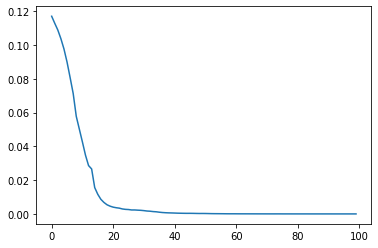

tensor([[-1.8288e-03,  2.0985e-04, -1.1735e-03,  1.7745e-03, -8.5474e-04,
          4.1637e-04,  2.2078e-03,  5.8683e-04, -1.2183e-03, -2.3924e-03,
         -6.5129e-04,  1.7254e-03,  1.2112e-03, -2.3432e-03,  8.8505e-04,
          2.5697e-04, -2.6051e-04, -7.0944e-04, -9.2045e-05,  4.1572e-04]],
       grad_fn=<SliceBackward>)
tensor([[ 0.0017,  0.0008,  0.0006,  0.0024,  0.0004, -0.0040,  0.0037, -0.0016,
          0.0014,  0.0010, -0.0014,  0.0024, -0.0015, -0.0027, -0.0009, -0.0030,
          0.0016, -0.0004, -0.0004,  0.0054]], grad_fn=<SliceBackward>)


In [41]:
N = 64
C = 2
L = 64
H = 20

vae = VAE(H, L, C)
# Optimizer for overfit tranning
optim = torch.optim.Adam(vae.parameters(), lr=1e-3)
train_overfit(vae, optim, max_iteration=100, sample_length=L)
print(vae.muy)
print(vae.log_var)

In [42]:
def train(model, opt, alpha=0.01, epochs=1, sample_length=32, batch_size=32):
  model.to(device)
  model.train()
  sample = torch.zeros((batch_size, 2, sample_length)).to(device=device, dtype=dtype)
  L = X_train.shape[2]
  loss_hist = []
  muy_hist = []
  min_loss = 1000
  for e in range(epochs):
    for iter in range(int(X_train.shape[2]/batch_size)):
      for i in range(batch_size):
        start = np.random.randint(0,L - sample_length)
        sample[i,:,:] = X_train[0,:,start:start + sample_length]
      x_hat, muy, log_var = model(sample)
      loss, raito = loss_fn(sample, x_hat, muy, log_var, alpha)
      loss.backward()
      opt.step()
      opt.zero_grad()
      if loss.item() < min_loss:
        min_loss = loss.item()
      if loss_hist:
        loss_hist.append(loss.item()*0.1 + loss_hist[-1]*0.9)
      else:
        loss_hist.append(loss.item())
      # muy_hist.append(muy_hist[-1]*0.9 + muy)
    print('epoch: ', e, ' min loss = ', min_loss, 'evg loss ', loss_hist[-1])
    plt.plot(list(np.arange(len(loss_hist))), loss_hist)
    plt.show()

In [53]:
N = 64
C = 2
L = 64
H = 128

vae = VAE(H, L, C)


In [54]:
optim = torch.optim.Adam(vae.parameters(), lr=5e-4)

epoch:  0  min loss =  0.031746815890073776 evg loss  0.061484254363026354


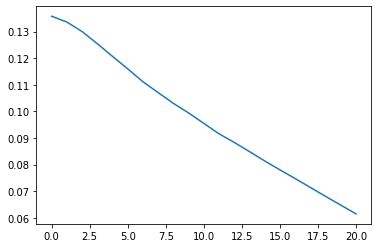

epoch:  1  min loss =  0.014119379222393036 evg loss  0.02210167651927287


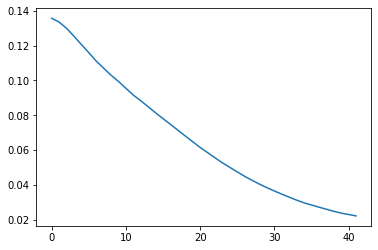

epoch:  2  min loss =  0.01298493891954422 evg loss  0.014705336846135517


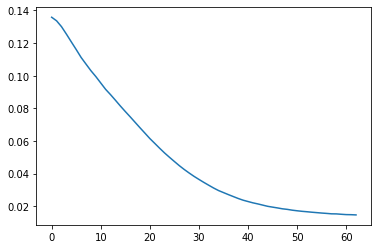

epoch:  3  min loss =  0.012632380239665508 evg loss  0.013677240236381526


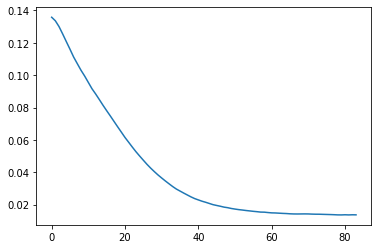

epoch:  4  min loss =  0.012632380239665508 evg loss  0.013332453416414959


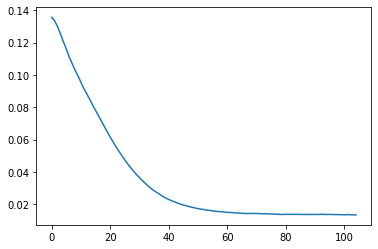

epoch:  5  min loss =  0.011779800988733768 evg loss  0.013247698508872387


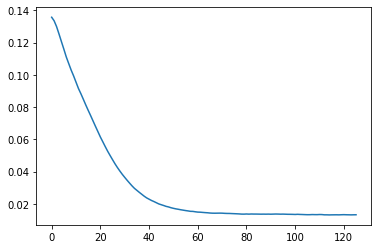

epoch:  6  min loss =  0.011779800988733768 evg loss  0.013104726050948935


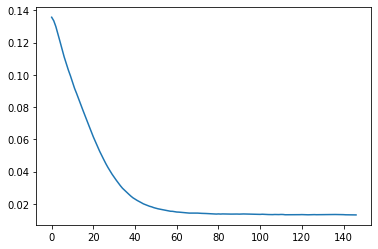

epoch:  7  min loss =  0.011779800988733768 evg loss  0.013107226911456802


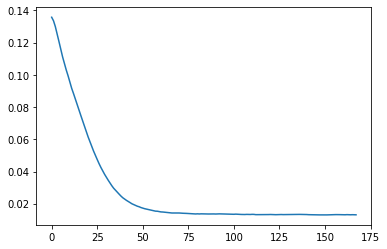

epoch:  8  min loss =  0.011779800988733768 evg loss  0.013384632399987675


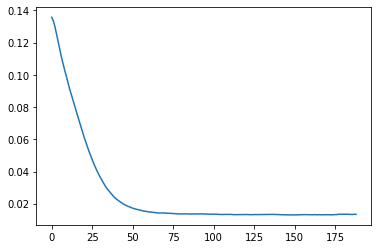

epoch:  9  min loss =  0.011779800988733768 evg loss  0.01342126073415977


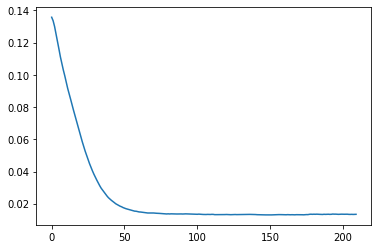

epoch:  10  min loss =  0.011779800988733768 evg loss  0.013292372560269203


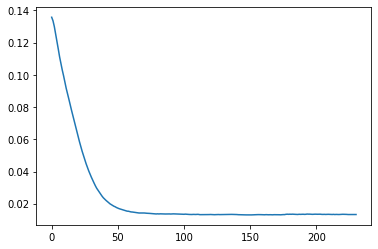

epoch:  11  min loss =  0.011779800988733768 evg loss  0.01385897489660232


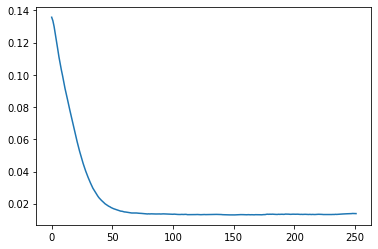

epoch:  12  min loss =  0.011779800988733768 evg loss  0.013622676898145704


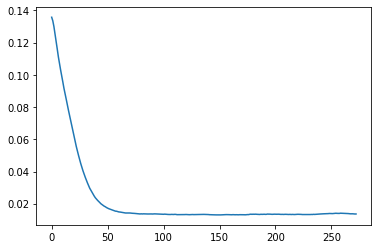

epoch:  13  min loss =  0.011779800988733768 evg loss  0.012978969503744086


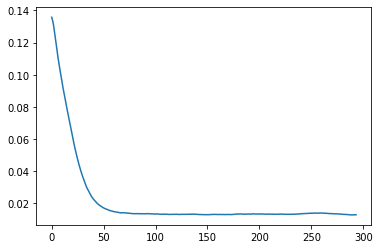

epoch:  14  min loss =  0.011779800988733768 evg loss  0.012944625178921454


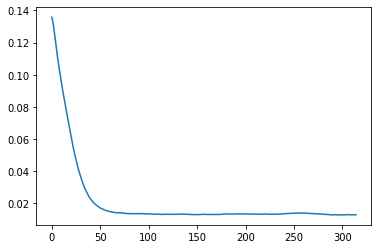

epoch:  15  min loss =  0.011779800988733768 evg loss  0.012822882406421685


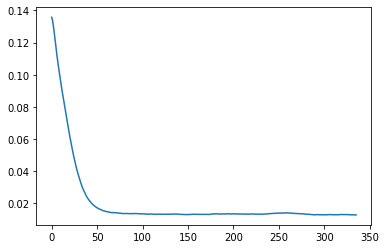

epoch:  16  min loss =  0.011779800988733768 evg loss  0.012621234886416987


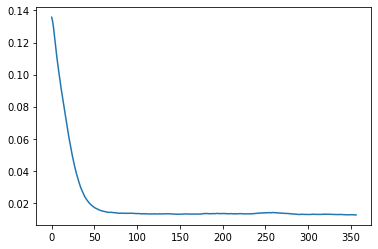

epoch:  17  min loss =  0.01152923982590437 evg loss  0.012368842249890615


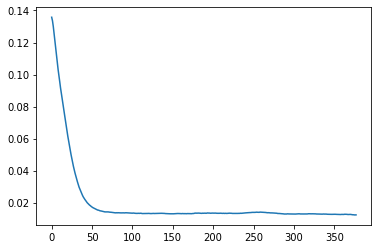

epoch:  18  min loss =  0.01030734833329916 evg loss  0.011600582070139916


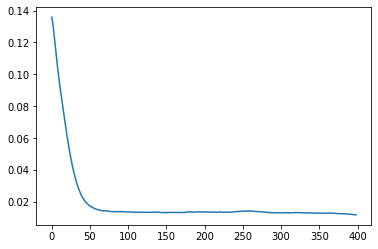

epoch:  19  min loss =  0.010196524672210217 evg loss  0.010928627140624685


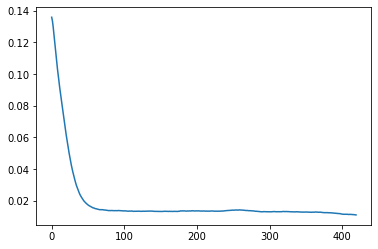

epoch:  20  min loss =  0.009842531755566597 evg loss  0.011481171600479343


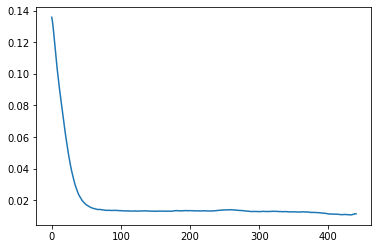

epoch:  21  min loss =  0.009486761875450611 evg loss  0.010765341933692867


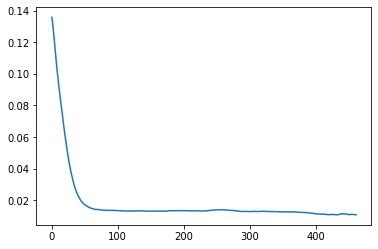

epoch:  22  min loss =  0.00902872160077095 evg loss  0.009904272116410361


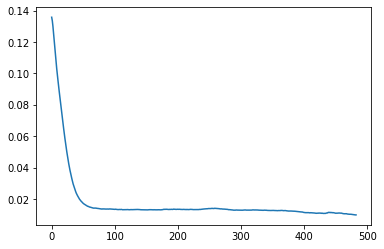

epoch:  23  min loss =  0.008279956877231598 evg loss  0.00955124728326405


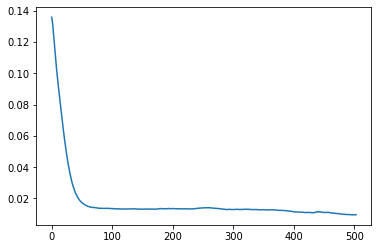

epoch:  24  min loss =  0.00823845062404871 evg loss  0.010399848348239411


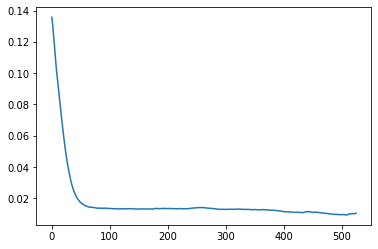

epoch:  25  min loss =  0.00823845062404871 evg loss  0.010400276908067852


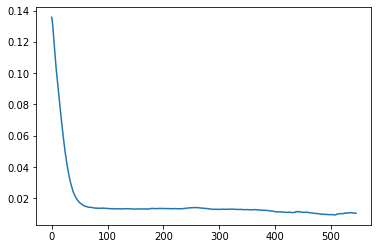

epoch:  26  min loss =  0.007418347056955099 evg loss  0.00934681141108077


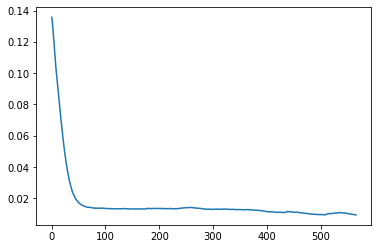

epoch:  27  min loss =  0.007418347056955099 evg loss  0.009520760871907334


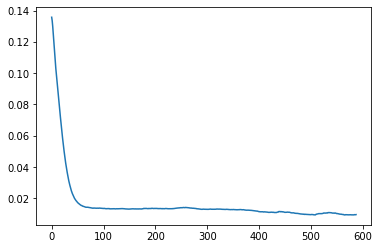

epoch:  28  min loss =  0.007418347056955099 evg loss  0.009207691929017525


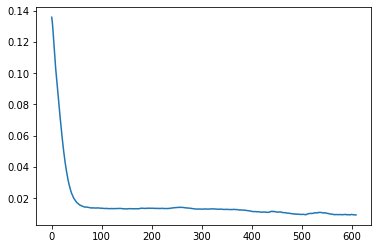

epoch:  29  min loss =  0.007418347056955099 evg loss  0.009110394243236954


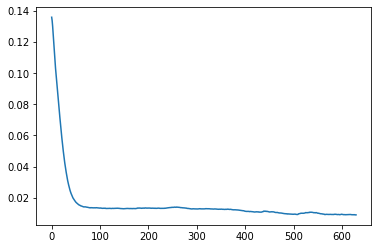

epoch:  30  min loss =  0.007271790876984596 evg loss  0.008784533146638074


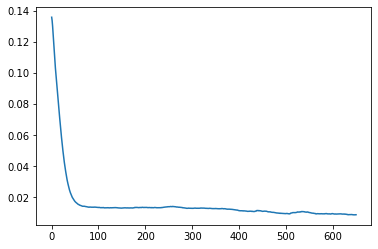

epoch:  31  min loss =  0.007271790876984596 evg loss  0.00903945425618364


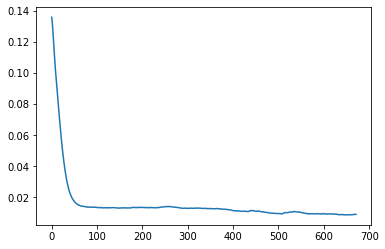

epoch:  32  min loss =  0.007271790876984596 evg loss  0.009077713515414594


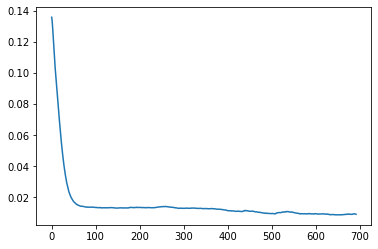

epoch:  33  min loss =  0.007271790876984596 evg loss  0.008741273073511491


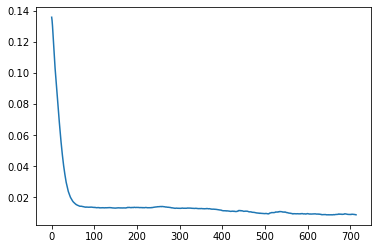

epoch:  34  min loss =  0.007271790876984596 evg loss  0.008800395405099186


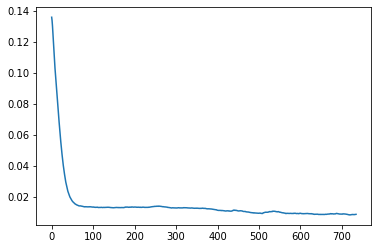

epoch:  35  min loss =  0.007271790876984596 evg loss  0.009283358952057277


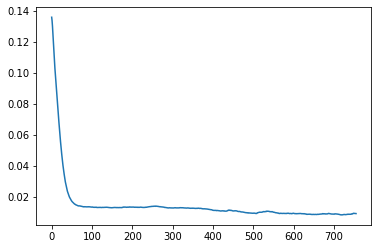

epoch:  36  min loss =  0.007271790876984596 evg loss  0.009357829956821334


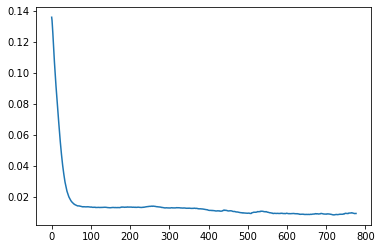

epoch:  37  min loss =  0.007271790876984596 evg loss  0.008750297681428926


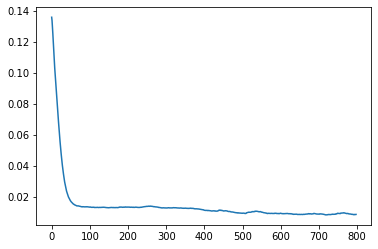

epoch:  38  min loss =  0.007271790876984596 evg loss  0.00942455605377771


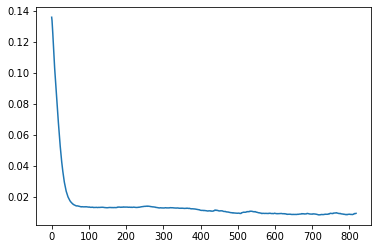

epoch:  39  min loss =  0.007271790876984596 evg loss  0.009067233836063131


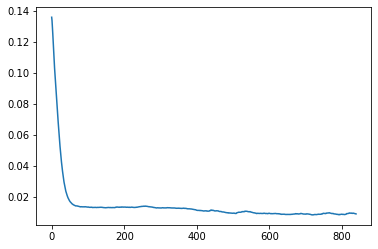

epoch:  40  min loss =  0.007271790876984596 evg loss  0.00833712209792302


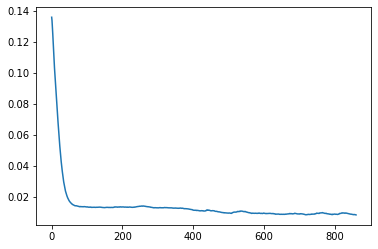

epoch:  41  min loss =  0.006828287150710821 evg loss  0.007985980042247053


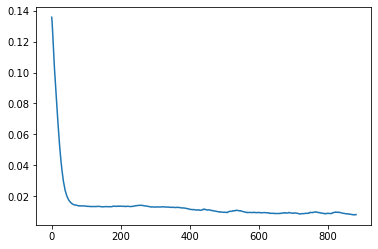

epoch:  42  min loss =  0.006392769515514374 evg loss  0.0071563481347614215


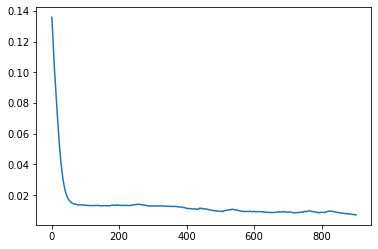

epoch:  43  min loss =  0.006392769515514374 evg loss  0.00748177821601016


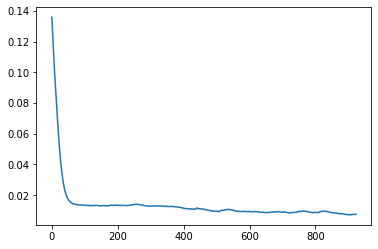

epoch:  44  min loss =  0.006392769515514374 evg loss  0.008095019393260197


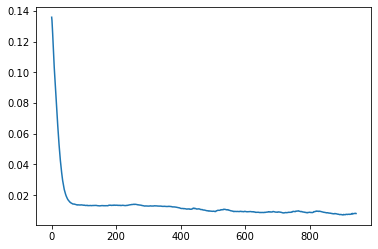

epoch:  45  min loss =  0.006367511115968227 evg loss  0.007003526955797875


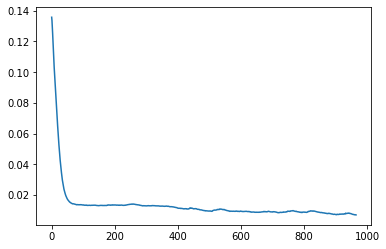

epoch:  46  min loss =  0.005321715027093887 evg loss  0.007086503034486869


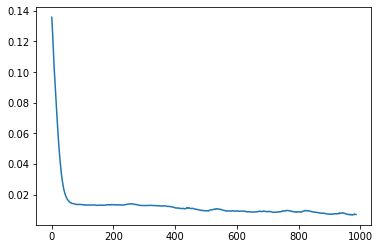

epoch:  47  min loss =  0.004927128553390503 evg loss  0.005941621900510832


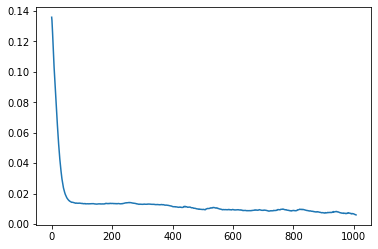

epoch:  48  min loss =  0.0040945131331682205 evg loss  0.004685922508063641


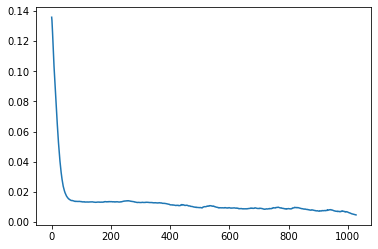

epoch:  49  min loss =  0.0038024019449949265 evg loss  0.0041766344419327545


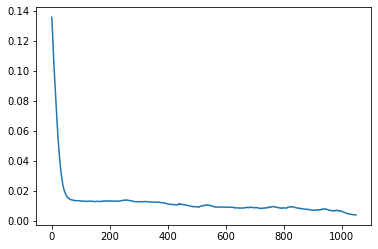

epoch:  50  min loss =  0.0036055613309144974 evg loss  0.004070267984055445


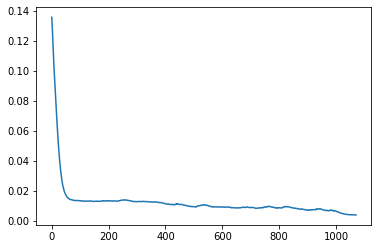

epoch:  51  min loss =  0.0036055613309144974 evg loss  0.00411162834911641


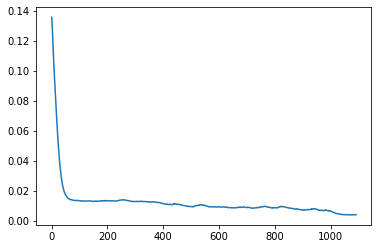

epoch:  52  min loss =  0.0036055613309144974 evg loss  0.0045120886601246885


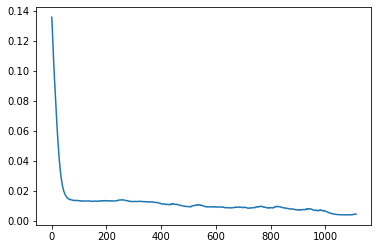

epoch:  53  min loss =  0.0036055613309144974 evg loss  0.0044090184226829076


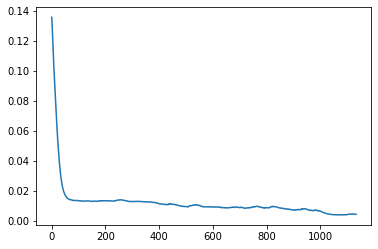

epoch:  54  min loss =  0.003604636527597904 evg loss  0.004464603345697356


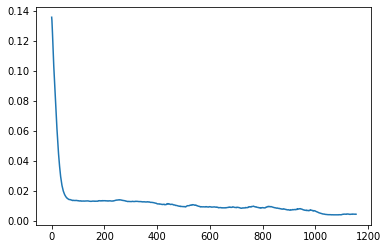

epoch:  55  min loss =  0.003604636527597904 evg loss  0.005303167268035323


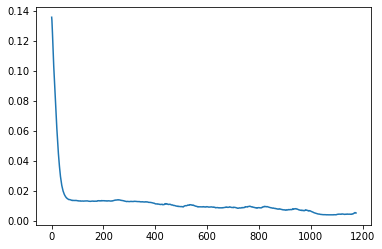

epoch:  56  min loss =  0.003604636527597904 evg loss  0.005551121571275816


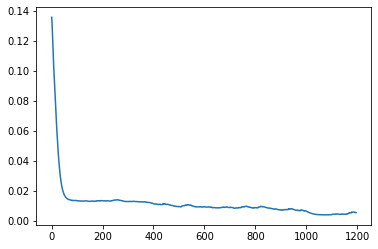

epoch:  57  min loss =  0.003604636527597904 evg loss  0.004631646197634083


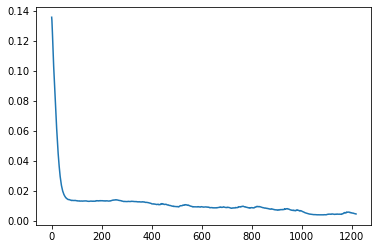

epoch:  58  min loss =  0.003498271107673645 evg loss  0.004077564210627086


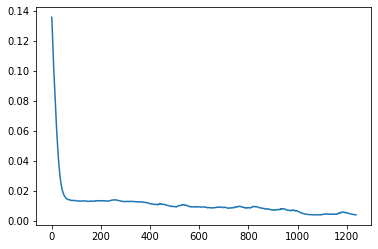

epoch:  59  min loss =  0.003285791724920273 evg loss  0.003964182475746769


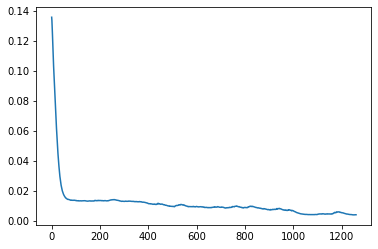

epoch:  60  min loss =  0.003285791724920273 evg loss  0.003923828757317755


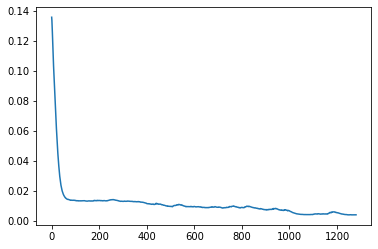

epoch:  61  min loss =  0.003285791724920273 evg loss  0.00390844293333725


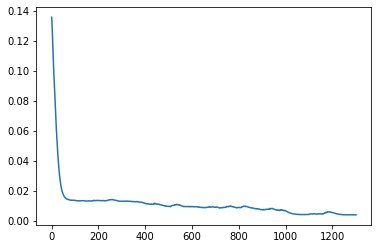

epoch:  62  min loss =  0.0032207840122282505 evg loss  0.004064069022061824


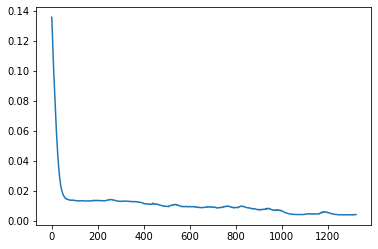

epoch:  63  min loss =  0.0032207840122282505 evg loss  0.0042266296935176435


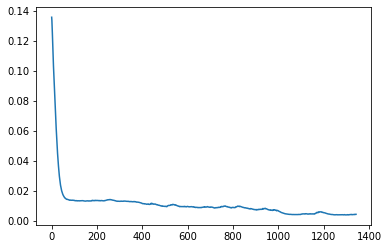

epoch:  64  min loss =  0.003136088838800788 evg loss  0.0036958692869050254


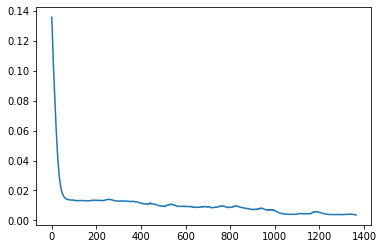

epoch:  65  min loss =  0.0031154751777648926 evg loss  0.0038847306525695985


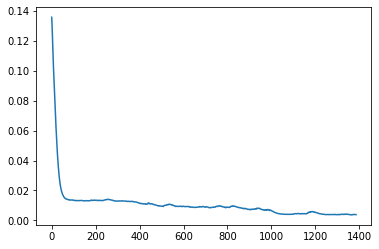

epoch:  66  min loss =  0.0031154751777648926 evg loss  0.0038242741066913987


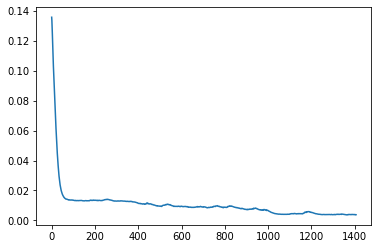

epoch:  67  min loss =  0.0031154751777648926 evg loss  0.004038461114426152


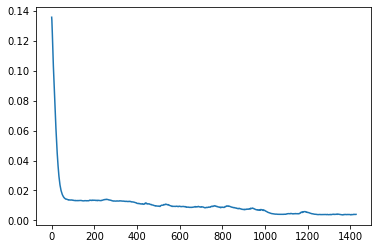

epoch:  68  min loss =  0.0031154751777648926 evg loss  0.004208092577415903


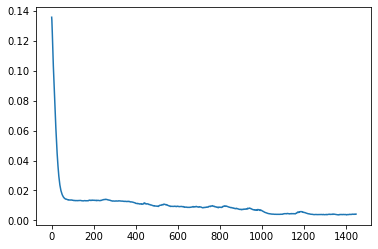

epoch:  69  min loss =  0.0031154751777648926 evg loss  0.003833357555435555


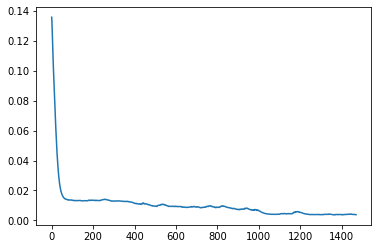

epoch:  70  min loss =  0.0030638198368251324 evg loss  0.0034232150575758203


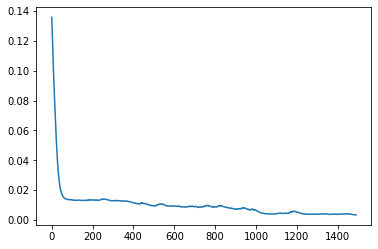

epoch:  71  min loss =  0.0030085835605859756 evg loss  0.0033344563590645216


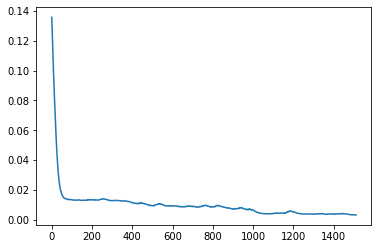

epoch:  72  min loss =  0.00297275697812438 evg loss  0.0035265827381639643


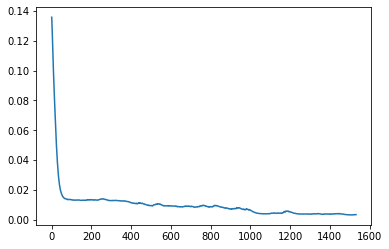

epoch:  73  min loss =  0.00297275697812438 evg loss  0.003619375438392186


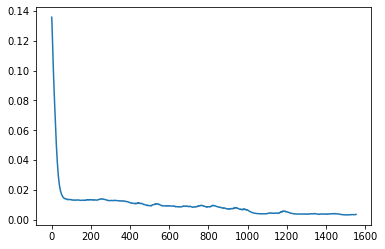

epoch:  74  min loss =  0.00297275697812438 evg loss  0.00396908116120964


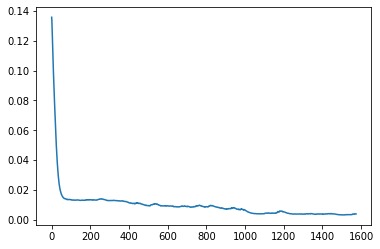

epoch:  75  min loss =  0.00297275697812438 evg loss  0.004424933304440744


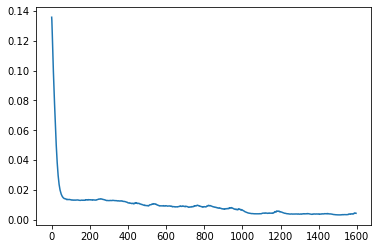

epoch:  76  min loss =  0.00297275697812438 evg loss  0.004201202851001759


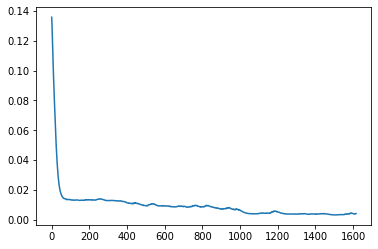

epoch:  77  min loss =  0.00297275697812438 evg loss  0.0038599396436822296


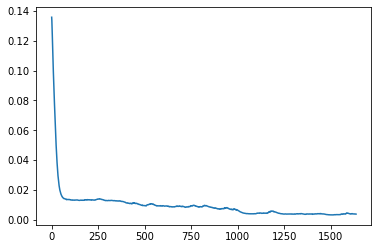

epoch:  78  min loss =  0.00297275697812438 evg loss  0.0037599216260575303


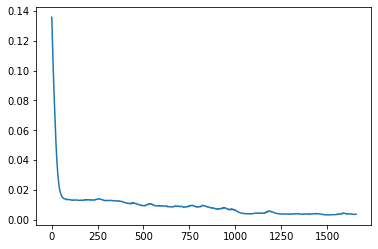

epoch:  79  min loss =  0.00297275697812438 evg loss  0.0035748337929949066


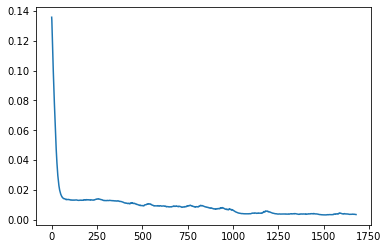

epoch:  80  min loss =  0.00297275697812438 evg loss  0.003737225169972164


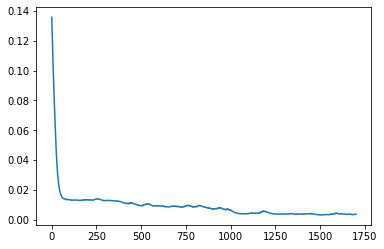

epoch:  81  min loss =  0.002949391957372427 evg loss  0.0034347165320116123


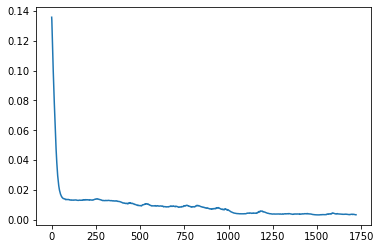

epoch:  82  min loss =  0.002890062052756548 evg loss  0.0033197946077793967


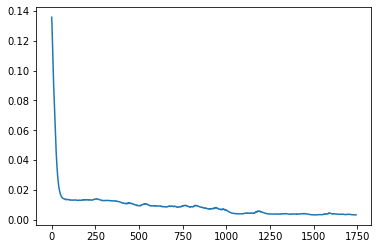

epoch:  83  min loss =  0.002890062052756548 evg loss  0.0034639244214702044


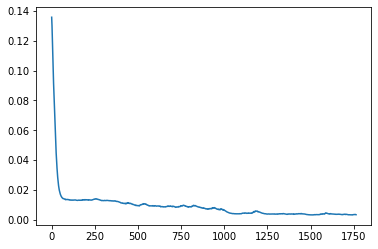

epoch:  84  min loss =  0.002890062052756548 evg loss  0.0035327490523420365


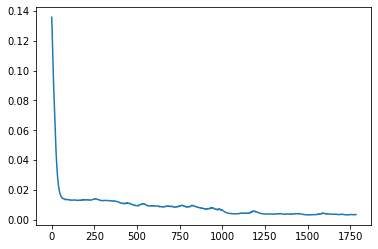

epoch:  85  min loss =  0.0028186964336782694 evg loss  0.0036622830000671847


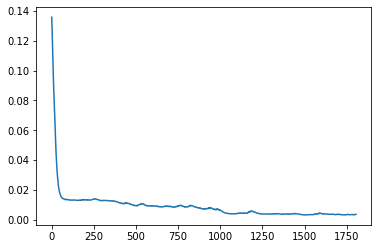

epoch:  86  min loss =  0.0028186964336782694 evg loss  0.004207015573729259


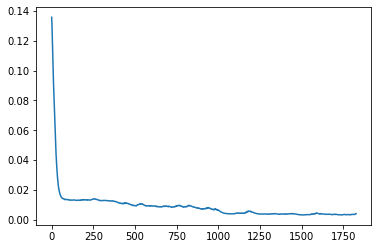

epoch:  87  min loss =  0.0028186964336782694 evg loss  0.004097904721388964


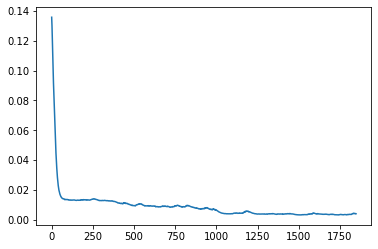

epoch:  88  min loss =  0.0028186964336782694 evg loss  0.0038374628146214274


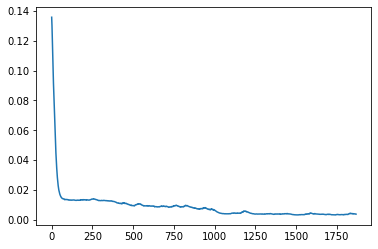

epoch:  89  min loss =  0.0028186964336782694 evg loss  0.0036954773363198075


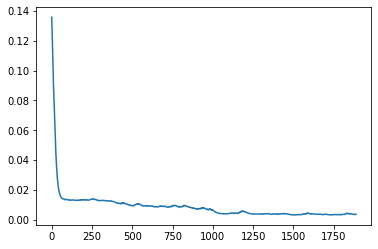

epoch:  90  min loss =  0.002771801548078656 evg loss  0.00344615135547163


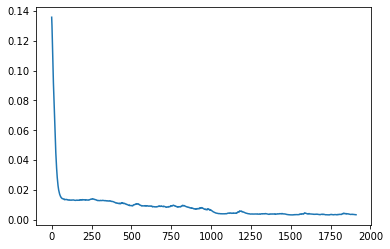

epoch:  91  min loss =  0.002771801548078656 evg loss  0.0035288413399637585


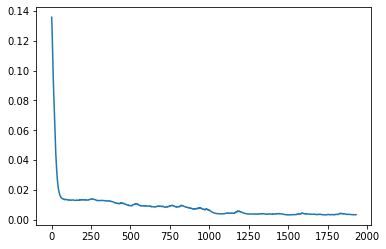

epoch:  92  min loss =  0.002771801548078656 evg loss  0.0033880726605042067


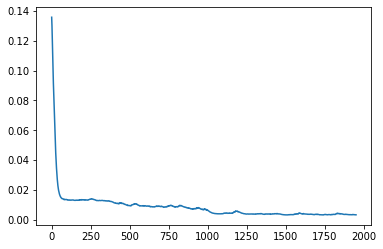

epoch:  93  min loss =  0.002771801548078656 evg loss  0.0033111314963030457


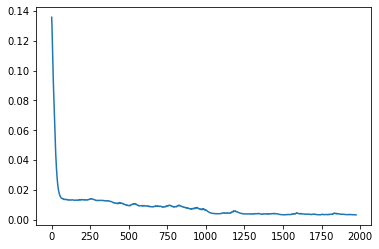

epoch:  94  min loss =  0.002771801548078656 evg loss  0.0035785406670424827


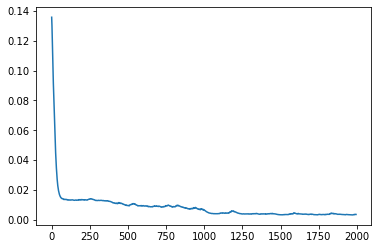

epoch:  95  min loss =  0.0027673025615513325 evg loss  0.003509888188800822


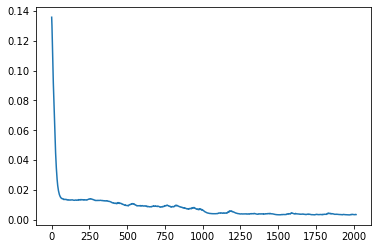

epoch:  96  min loss =  0.0027673025615513325 evg loss  0.003577642570580323


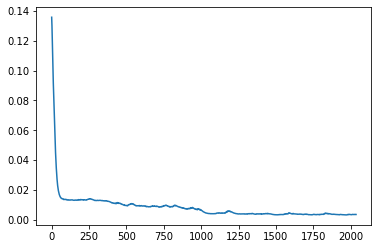

epoch:  97  min loss =  0.0027673025615513325 evg loss  0.00354021670995475


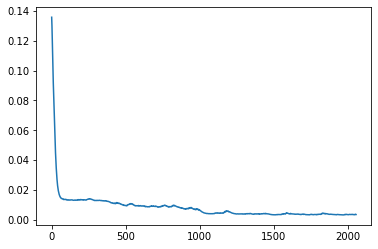

epoch:  98  min loss =  0.0027673025615513325 evg loss  0.00358777405190072


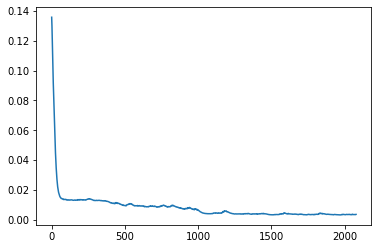

epoch:  99  min loss =  0.0027673025615513325 evg loss  0.003918983766001317


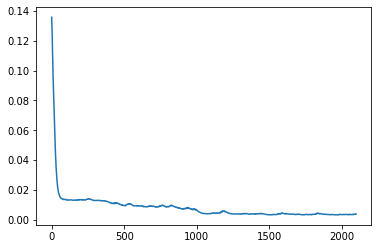

In [55]:
train(vae, optim, epochs=100, alpha=0.01, batch_size=N, sample_length=L)

In [56]:
X_reconstruct = torch.zeros_like(X_test)
vae.to(device)
for i in range(int(X_test.shape[2]/L)-1):
  X_reconstruct[0,:,i*L:i*L+L], _, _ = vae(
      X_test[0,:,i*L:(i+1)*L].reshape(-1,2,L).to(device=device, dtype=dtype)
  )
print(X_reconstruct.shape)

torch.Size([1, 2, 223])


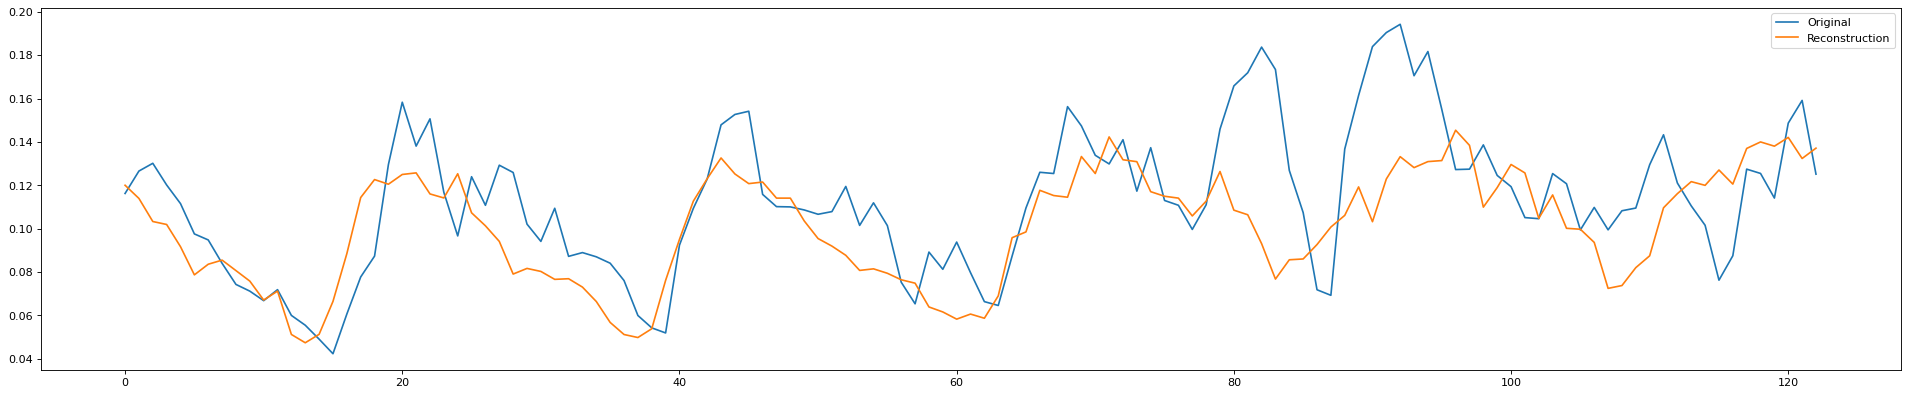

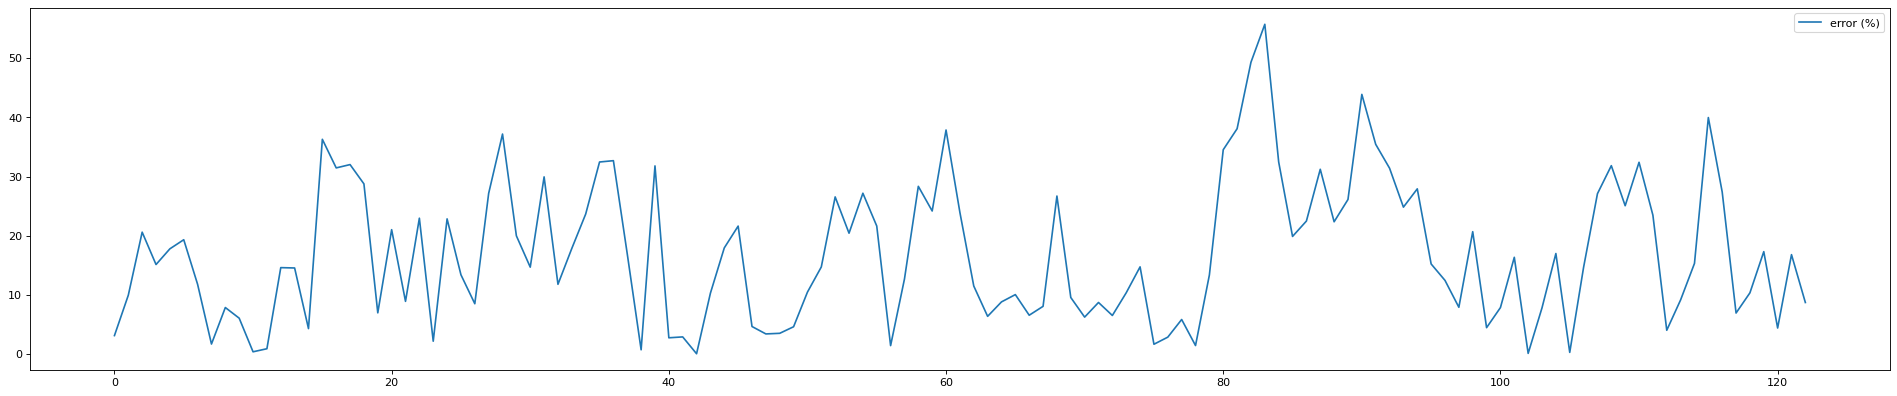

In [57]:
fig=plt.figure(figsize=(30,6), dpi=80)
plt.plot(np.arange(X_test.shape[2]-100), X_test[0,0,:-100].detach().numpy(), label='Original')
# plt.legend()
# plt.show()
# fig=plt.figure(figsize=(30,6), dpi=80)

plt.plot(np.arange(X_reconstruct.shape[2]-100), X_reconstruct[0,0,:-100].detach().numpy(), label='Reconstruction')
plt.legend()
plt.show()
fig=plt.figure(figsize=(30,6), dpi=80)
error = 100*torch.abs(X_reconstruct[0,0,:-100] - X_test[0,0,:-100])/torch.max(X_reconstruct[0,0,:-100], X_test[0,0,:-100])
plt.plot(np.arange(X_reconstruct.shape[2]-100), error.detach().numpy(), label='error (%)')
plt.legend()
plt.show()

torch.Size([1, 2, 1400])


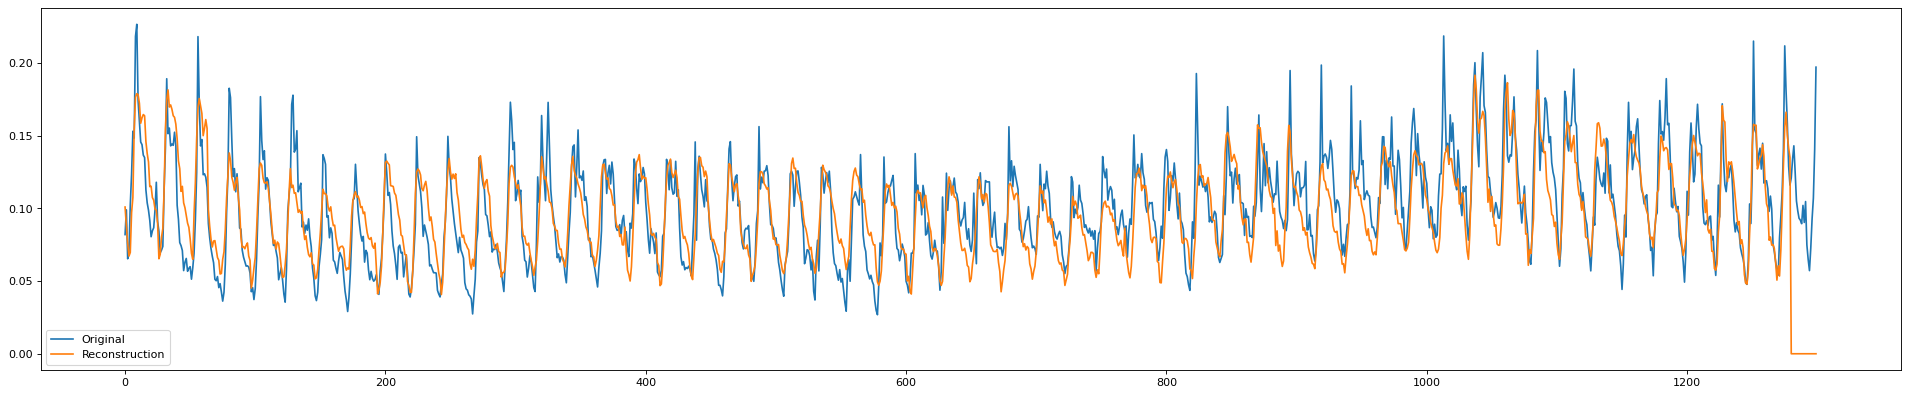

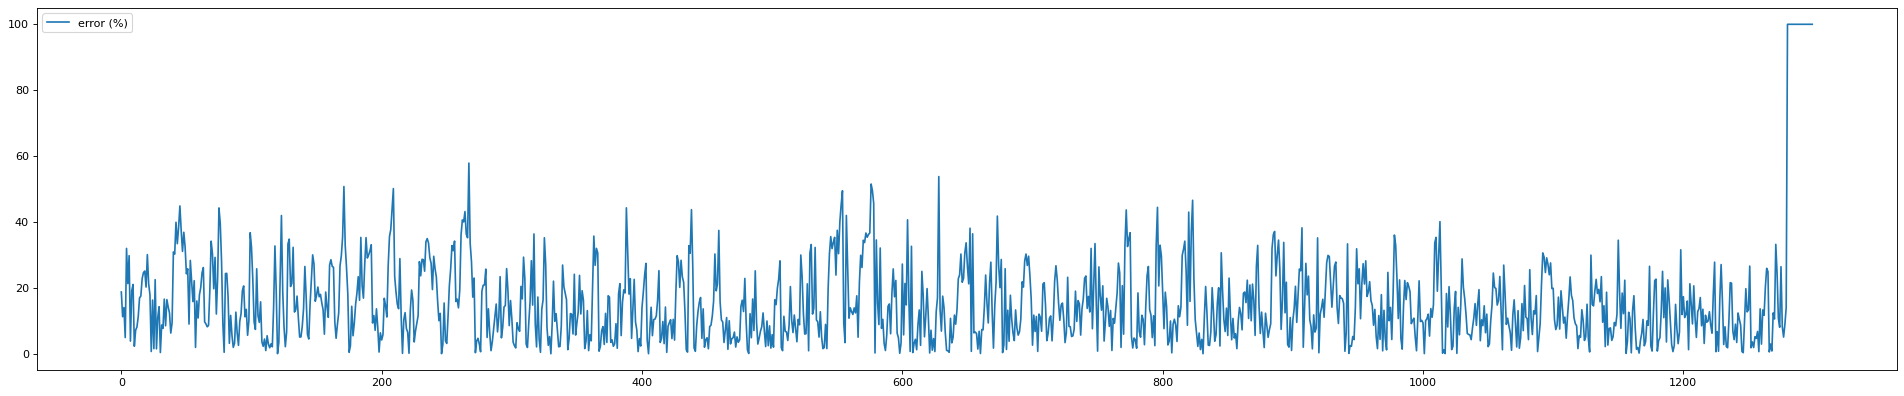

In [58]:
X_reconstruct = torch.zeros_like(X_train)
vae.to(device)
for i in range(int(X_train.shape[2]/L)-1):
  X_reconstruct[0,:,i*L:i*L+L], _, _ = vae(
      X_train[0,:,i*L:(i+1)*L].reshape(-1,2,L).to(device=device, dtype=dtype)
  )
print(X_reconstruct.shape)
fig=plt.figure(figsize=(30,6), dpi=80)
plt.plot(np.arange(X_train.shape[2]-100), X_train[0,0,:-100].detach().numpy(), label='Original')
# plt.legend()
# plt.show()
# fig=plt.figure(figsize=(30,6), dpi=80)

plt.plot(np.arange(X_reconstruct.shape[2]-100), X_reconstruct[0,0,:-100].detach().numpy(), label='Reconstruction')
plt.legend()
plt.show()
fig=plt.figure(figsize=(30,6), dpi=80)
error = 100*torch.abs(X_reconstruct[0,0,:-100] - X_train[0,0,:-100])/torch.max(X_reconstruct[0,0,:-100], X_train[0,0,:-100])
plt.plot(np.arange(X_reconstruct.shape[2]-100), error.detach().numpy(), label='error (%)')
plt.legend()
plt.show()